In [1]:
import os
import autogen
from autogen.cache import Cache

from finrobot.utils import register_keys_from_json
from finrobot.toolkits import register_toolkits
from finrobot.functional import (
    ReportChartUtils,
    ReportAnalysisUtils,
    IPythonUtils,
    ReportLabUtils,
    TextUtils,
)
from finrobot.data_source import FMPUtils
from textwrap import dedent

/Users/zhang/miniconda3/envs/finrobot/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_client_cls" in LLMConfigEntry has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/zhang/miniconda3/envs/finrobot/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_client_cls" in AnthropicLLMConfigEntry has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/zhang/miniconda3/envs/finrobot/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_client_cls" in BedrockLLMConfigEntry has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/zhang/miniconda3/

In [2]:
import os
print("CWD =", os.getcwd())
print("Files in CWD =", os.listdir(".")[:30])


CWD = /Users/zhang/FinRobot/submissions
Files in CWD = ['Untitled1.ipynb', 'Untitled.ipynb', '.ipynb_checkpoints', '.cache']


In [3]:
REPO_DIR = "/Users/zhang/FinRobot"

config_list = autogen.config_list_from_json(
    os.path.join(REPO_DIR, "OAI_CONFIG_LIST"),
    filter_dict={"model": ["gpt-4o-mini"]},
)

llm_config = {
    "config_list": config_list,
    "timeout": 120,
    "temperature": 0.5,
}

register_keys_from_json(os.path.join(REPO_DIR, "config_api_keys"))

work_dir = os.path.join(REPO_DIR, "report")
os.makedirs(work_dir, exist_ok=True)

In [4]:
system_message = dedent(
    f"""
    Role: Expert Investor
    Department: Finance
    Primary Responsibility: Generation of Customized Financial Analysis Reports

    Role Description:
    As an Expert Investor within the finance domain, your expertise is harnessed to develop bespoke Financial Analysis Reports that cater to specific client requirements. This role demands a deep dive into financial statements and market data to unearth insights regarding a company's financial performance and stability. Engaging directly with clients to gather essential information and continuously refining the report with their feedback ensures the final product precisely meets their needs and expectations.

    Key Objectives:

    Analytical Precision: Employ meticulous analytical prowess to interpret financial data, identifying underlying trends and anomalies.
    Effective Communication: Simplify and effectively convey complex financial narratives, making them accessible and actionable to non-specialist audiences.
    Client Focus: Dynamically tailor reports in response to client feedback, ensuring the final analysis aligns with their strategic objectives.
    Adherence to Excellence: Maintain the highest standards of quality and integrity in report generation, following established benchmarks for analytical rigor.
    Performance Indicators:
    The efficacy of the Financial Analysis Report is measured by its utility in providing clear, actionable insights. This encompasses aiding corporate decision-making, pinpointing areas for operational enhancement, and offering a lucid evaluation of the company's financial health. Success is ultimately reflected in the report's contribution to informed investment decisions and strategic planning.

    Reply TERMINATE when everything is settled.
    """
)
expert = autogen.AssistantAgent(
    name="Expert_Investor",
    system_message=system_message,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").endswith("TERMINATE"),
)
expert_shadow = autogen.AssistantAgent(
    name="Expert_Investor_Shadow",
    system_message=system_message,
    llm_config=llm_config,
)
user_proxy = autogen.UserProxyAgent(
    name="User_Proxy",
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").endswith("TERMINATE"),
    # human_input_mode="ALWAYS",
    human_input_mode="NEVER",
    # max_consecutive_auto_reply=10,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": work_dir,
        "use_docker": False,
    },
)

In [5]:
register_toolkits(
    [
        FMPUtils.get_sec_report,  # Retrieve SEC report url and filing date
        IPythonUtils.display_image,  # Display image in IPython
        TextUtils.check_text_length,  # Check text length
        ReportLabUtils.build_annual_report,  # Build annual report in designed pdf format
        ReportAnalysisUtils,  # Expert Knowledge for Report Analysis
        ReportChartUtils,  # Expert Knowledge for Report Chart Plotting
    ],
    expert,
    user_proxy,
)

In [8]:
def order_trigger(sender):
    # Check if the last message contains the path to the instruction text file
    return "instruction & resources saved to" in sender.last_message()["content"]


def order_message(recipient, messages, sender, config):
    # Extract the path to the instruction text file from the last message
    full_order = recipient.chat_messages_for_summary(sender)[-1]["content"]
    txt_path = full_order.replace("instruction & resources saved to ", "").strip()
    txt_path = txt_path.splitlines()[0].strip()
    with open(txt_path, "r") as f:
        instruction = f.read() + "\n\nReply TERMINATE at the end of your response."
    return instruction


# Since 10-K section is not short, we need an extra nested chat to analyze the contents
expert.register_nested_chats(
    [
        {
            "sender": expert,
            "recipient": expert_shadow,
            "message": order_message,
            "summary_method": "last_msg",
            "max_turns": 2,
            "silent": True,  # mute the chat summary
        }
    ],
    trigger=order_trigger,
)

In [26]:
company = "APPL"
ticker = "APPL"
competitors = ["GOOGL","MSFT","META",'NVDA']
fyear = "2024"

task = dedent(
    f"""
    With the tools you've been provided, write an annual report based on {company}'s and{competitors}'s{fyear} 10-k report, format it into a pdf.
    Pay attention to the followings:
    - Explicitly explain your working plan before you kick off.
    - Use tools one by one for clarity, especially when asking for instructions.
    - All your file operations should be done in "{work_dir}".
    - When calling build_annual_report, you MUST set save_path to exactly: "{work_dir}/{ticker}_Annual_Report_{fyear}.pdf" (so each company keeps its own PDF and nothing is overwritten).
    - Display any image in the chat once generated.
    - For competitors analysis, strictly follow my prompt and use data only from the financial metics table, do not use similar sentences in other sections, delete similar setence, classify it into either of the two. The last sentence always talks about the Discuss how {company}’s performance over these years and across these metrics might justify or contradict its current market valuation (as reflected in the EV/EBITDA ratio).
    - Each paragraph in the first page(business overview, market position and operating results) should be between 150 and 160 words, each paragraph in the second page(risk assessment and competitors analysis) should be between 500 and 600 words, don't generate the pdf until this is explicitly fulfilled.
    - CRITICAL: The first page has THREE different sections. You MUST write three DIFFERENT paragraphs:
      (1) Business Overview: use ONLY content from analyze_company_description (what the company does, industry, business model). Do NOT put risk or competition narrative here.
      (2) Market Position: use content from analyze_business_highlights and company description about market share, positioning, segments. Do NOT copy the same text as Business Overview or Operating Results.
      (3) Operating Results: use content from analyze_income_stmt, analyze_balance_sheet, analyze_cash_flow (revenue, earnings, margins, key financial results). Do NOT copy the same text as the other two sections.
      Never use the same paragraph for more than one of these three; each must be distinct in content and source.
"""
)

with Cache.disk() as cache:
    user_proxy.initiate_chat(
        recipient=expert, message=task, max_turns=50, summary_method="last_msg"
    )


User_Proxy (to Expert_Investor):


With the tools you've been provided, write an annual report based on APPL's and['GOOGL', 'MSFT', 'META', 'NVDA']'s2024 10-k report, format it into a pdf.
Pay attention to the followings:
- Explicitly explain your working plan before you kick off.
- Use tools one by one for clarity, especially when asking for instructions.
- All your file operations should be done in "/Users/zhang/FinRobot/report".
- When calling build_annual_report, you MUST set save_path to exactly: "/Users/zhang/FinRobot/report/APPL_Annual_Report_2024.pdf" (so each company keeps its own PDF and nothing is overwritten).
- Display any image in the chat once generated.
- For competitors analysis, strictly follow my prompt and use data only from the financial metics table, do not use similar sentences in other sections, delete similar setence, classify it into either of the two. The last sentence always talks about the Discuss how APPL’s performance over these years and across these met

In [19]:
import os
from pathlib import Path
from datetime import datetime

work_dir = Path("/Users/zhang/FinRobot/report")

for f in sorted(work_dir.iterdir()):
    if f.is_file():
        mtime = datetime.fromtimestamp(f.stat().st_mtime)
        print(f"{f.name:40s}  {mtime}")


2023-07-27_10-K_msft-20230630.htm.pdf     2026-02-10 10:28:35.501768
Microsoft_Annual_Report_2023.pdf          2026-02-10 10:28:35.502439
NVDA_report.pdf                           2026-02-10 10:28:35.502959
NextEra_Energy_Annual_Report_2024.pdf     2026-02-20 22:05:19.359685
googl_business_overview.txt               2026-02-20 22:46:19.786239
googl_competitors_analysis.txt            2026-02-20 22:44:34.702087
googl_market_position.txt                 2026-02-20 22:43:30.185290
googl_operating_results.txt               2026-02-20 22:43:48.737693
googl_pe_eps_performance.png              2026-02-20 22:45:00.141982
googl_risk_assessment.txt                 2026-02-20 22:43:56.859056
googl_share_performance.png               2026-02-20 22:44:55.322936
nee_business_highlights.txt               2026-02-20 22:04:08.188878
nee_business_overview.txt                 2026-02-20 18:59:26.251672
nee_competitors_analysis.txt              2026-02-20 22:04:46.714899
nee_income_statement_analysis.txt 

Using: /Users/zhang/FinRobot/report/NextEra_Energy_Annual_Report_2024.pdf


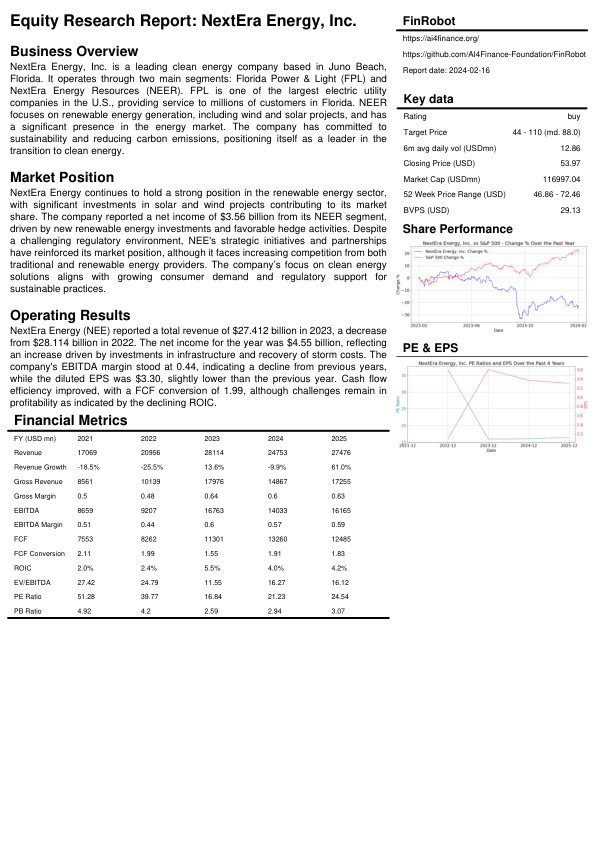

In [21]:
import fitz, io
from PIL import Image
from pathlib import Path

report_dir = Path("/Users/zhang/FinRobot/report")

pdf_path = max(report_dir.glob("*.pdf"), key=lambda p: p.stat().st_mtime)

print("Using:", pdf_path)

doc = fitz.open(pdf_path)
pix = doc[0].get_pixmap()
display(Image.open(io.BytesIO(pix.tobytes("png"))))
doc.close()
